Normalização do modelo BCS não linear

In [1]:
import matplotlib.pyplot as plt
import numpy as np
exec(compile(open('param.py', "rb").read(), 'param.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS

### Variáveis de entrada
f $\in$ (35,65) Hz <br>
zc $\in$ (0,100)% <br>
pm $\in$ ($2\cdot 10^6$) <br>

### Variáveis de estado
pbh $\in$ ($10^5, 8.5 \cdot 10^6$) <br>
pwh $\in$ ($2 \cdot 10^6, 5.2\cdot10^6$) <br>
q $\in (10^{-2},3\cdot 10^{⁻2})$ <br>

### Saídas
pin $\in$ ($40, 60.5) \cdot 10^6$ <br>
H $\in$ ($590, 850$) <br>

Função para retornar os valores de xc e x0 dado que<br>
$x_{min}<x<x_{max}$ <br>

Nova variável<br>

$xb=\frac{x-x0}{xc}$

Assim <br>

$x=xb\cdot xc+x0$

Fazendo com que a nova variável $0<xb<1$ <br>


In [2]:
def Fnorm(xlim):
    # Encontrar o fator de normalização
    # tal que xb=(x-x0)/xc
    # xmin<x<xmax
    # fazendo com que 0<xb<1
    x=(xlim[0],xlim[1]-xlim[0])
    return x
def normalizar(x,xnorm):
    xs=np.zeros((nx,1))
    for i in range(0,nx):
        xs[i]=(x[i]-xnorm[i,0])/xnorm[i,1]
    return xs
def desnormalizar(x,xnorm):
    xs=np.zeros((nx,1))
    for i in range(0,nx):
        xs[i]=x[i]*xnorm[i,1]+xnorm[i,0]
    return xs
def AplicaEscala(var,i):
    aux=var*xnorm[i,1]+xnorm[i,0]
    return aux
def normaliza_u(ux,unorm):
    aux=np.zeros((nu,1))
    for i in range(0,len(ux)):
       # aux[i]=(ux[i]-unorm[i,0])/unorm[i,1]
        aux[i,0]=(ux[i,0]-unorm[i,0])/unorm[i,1]
       # print(aux)
    return aux
def desnormalizar_u(ux,unorm):
    aux=np.zeros((nu,1))
    for i in range(0,len(ux)):
       # aux[i]=(ux[i]-unorm[i,0])/unorm[i,1]
        aux[i,0]=ux[i,0]*unorm[i,1]+unorm[i,0]
       # print(aux)
    return aux

Definindo os fatores de ajuste de escala a partir dos limites operacionais

In [3]:
# Valores máximos e mínimos para normalização
#Entradas
f_lim=(30,75); zclim=(0,100);pmlim=(1e6,2e6); H_lim=(590,850); pinlim=(40e6,60.5e6)
pbhlim=(100000,8.5e6); pwhlim=(2e6,5.2e6); qlim=(12/3600,55/3600)

In [4]:
normaliza=False
normaliza=True
pm=2e6; #Simplificando pm fixo
unorm=np.array([Fnorm(f_lim),Fnorm(zclim)])
xnorm= np.array([Fnorm(pbhlim),Fnorm(pwhlim),Fnorm(qlim), unorm[0,:],unorm[1,:]])
ynorm=np.array([Fnorm(pinlim),Fnorm(H_lim)])
xnorm
if normaliza==False:
    xnorm=np.array([[0,1],[0,1],[0,1],[0,1],[0,1]])
    unorm=np.array([[0,1],[0,1]])
    ynorm=np.array([[0,1],[0,1]])

#pbh  - pressão na bomba
#pwh - Pressão de fundo do poço,
#q - vazão
#PI índice de produtividade do poço
#PinC  pressão na choke
# Pressão de manifold

Definindo as variáveis simbólicas

In [5]:
# Criando simbolica
from casadi import *
nx = 3; nu = 2;
x = MX.sym("x",nx); # Estados
u = MX.sym("u",nu); # Exogena
dudt_max = MX.sym("dudt_max",2); # Exogena


In [6]:
pbh = AplicaEscala(x[0],0)
pwh = AplicaEscala(x[1],1)
q = AplicaEscala(x[2],2)
fq = u[0]
zc = u[1]
#zc = AplicaEscala(x[4],4)

In [7]:
# Entradas

fqref = u[0]*unorm[0,1]+unorm[0,0]; zcref = u[1]*unorm[1,1]+unorm[1,0];
pm=2e6;
#fq=fqref; zc=zcref;
#pm=(pm-xnorm[0,0])/xnorm[0,1]
pm
#pm = u[2];


2000000.0

Normalizando variáveis dependentes

In [8]:
# Calculo do HEAD e delta de press�o
q0 = q/Cq*(f0/fq);
H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2;

H = CH*H0*(fq/f0)**2; # Head
Pp = rho*g*H;
# Calculo da press�o de intake
F1 = 0.158*((rho*L1*q**2)/(D1*A1**2))*(mu/(rho*D1*q))**(1/4);
F2 = 0.158*((rho*L2*q**2)/(D2*A2**2))*(mu/(rho*D2*q))**(1/4);

In [9]:
P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4;
pin = pbh - rho*g*h1 - F1
P = Cp*P0*(fq/f0)**3; # Potencia
I = Inp*P/Pnp;      # Corrente

In [10]:
F1

MX(@1=(0.00333333+(0.0119444*x[2])), ((0.158*((475000*sq(@1))/6.6775e-06))*pow((0.025/(96.52*@1)),0.25)))

In [11]:
# Vazao do reservatorio e vazao da choke
qr  = PI*(pr - pbh);
qr


MX((2.32e-09*(12600000-(100000+(8400000*x[0])))))

In [12]:
qc  = Cc*(zc/100)*sign((pwh - pm))*sqrt(casadi.fabs(pwh - pm));

In [13]:
dpbhdt = b1/V1*(qr - q);
dpwhdt = b2/V2*(q - qc);
dqdt = 1/M*(pbh - pwh - rho*g*hw - F1 - F2 + Pp);


Aplicar escala nas derivadas

In [14]:
if normaliza==True:
    dpbhdt=dpbhdt*xnorm[0,1]
    dpwhdt=dpwhdt*xnorm[1,1]
    dqdt=dqdt*xnorm[2,1]



In [15]:
# Função casadi
dxdt = vertcat(dpbhdt,dpwhdt,dqdt)
Eq_Estado = Function('Eq_Estado',[x,u],[dxdt],
                     ['x','u'],['dxdt'])

y=vertcat(pin,H);
ny = y.size1()

In [16]:
# Equações algébricas
sea_nl = Function('sea_nl',[x,u],[y,pin,H],\
                  ['x','u'],['y','pin','H']); # Sistema de Eq. Algebricas variaveis de sa�da



In [17]:
BCS={
     'x': x,
     'u': u,
     'y': y,
     'nx': nx,
     'nu': nu,
     'ny': ny,
     'NaoLinear': {'sedo_nl': Eq_Estado(x,u),
                   'sea_nl': sea_nl
                   }
}


In [18]:
#% Função objetivo
dxdt_0 = Eq_Estado(BCS['x'], BCS['u'])
J = sum1(dxdt_0**2)

In [19]:
#% Otimizador
opt={
     'ipopt':{
         'print_level':0,
         'acceptable_tol':1e-8,
         'acceptable_obj_change_tol':1e-6,
         'max_iter':50
         },
     'print_time':0,
     }

opt['ipopt']['print_level']=0;# %0,3
opt['print_time']=0;
opt['ipopt']['acceptable_tol']=1e-8;
opt['ipopt']['acceptable_obj_change_tol']=1e-6;
opt['ipopt']['max_iter']=50;

In [20]:
MMQ = {'x':BCS['x'], 'f':J, 'p':BCS['u']}

In [21]:
solver = nlpsol('solver', 'ipopt', MMQ, opt)

In [22]:
# Restrições das variaveis de decis�o
# minimo
args={
      'lbx': np.zeros((nx,1)),
# m�ximo
      'ubx':np.full((nx, 1), np.inf)
      }

# Solu��o do otimizador
sol=solver(x0=BCS['x'], lbx=args['lbx'], ubx=args['ubx'], p=BCS['u']);
#yss=sea_nl(sol['x'],BCS['u'])


In [23]:
# Estacionario = Function('Estacionario',[BCS['x'],BCS['u']],\
#     [sol['x'],yss[0]],\
#     ['x0','uss'],['xss','yss']);

# BCS['Estacionario'] = Estacionario;

In [24]:
f_ss,zc_ss= (np.array([50, 50]))

In [25]:
uss = np.array([[f_ss],[zc_ss]]); # Entradas do estacionario

uss


array([[50],
       [50]])

In [26]:
#% Calculo do estacionario

#x0 = [0.2,0.5,0.5,0.5,0.5]
#x0 = np.array([8311024.82175957,2990109.06207437,0.00995042241351780,50,50]);

x0 = np.array([8311024.82175957,2990109.06207437,0.00995042241351780]);

In [27]:
if normaliza==True:
    x0_n=normalizar(x0,xnorm)
    uss_n=normaliza_u(uss,unorm)
else:
    x0_n=x0
    uss_n=uss

In [28]:
H

MX(@1=u[0], @2=(((0.00333333+(0.0119444*x[2]))/0.937982)*(60/@1)), ((0.99925*(959.7+((-1245400*sq(@2))+(7495.9*@2))))*sq((@1/60))))

In [29]:
uss_n

array([[0.44444444],
       [0.5       ]])

In [30]:
x0_n

array([[0.97750295],
       [0.30940908],
       [0.55398885]])

In [31]:
# args['lbx'][3] = uss[0]
# args['ubx'][3] = uss[0]  # bounds freq. solver
# args['lbx'][4] = uss[1]
# args['ubx'][4] = uss[1]   # bounds zc solver
#sol=solver('x0',x0, 'lbx', args['lbx'], 'ubx', args['ubx'], 'p', uss);
#sol=solver(x0=x0_n,lbx=args['lbx'], ubx=args['ubx'], p=uss_n)
sol_n=solver(x0=x0_n, p=uss_n)
xss_n=sol_n['x']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [32]:
if normaliza==False:
    sol=solver(x0=x0, p=uss)
    xss=sol['x']

In [33]:
#Eq de medição


In [34]:
sol_n['x']

DM([1.48299, 0.309409, -0.270739])

In [35]:
xss = desnormalizar(sol_n['x'],xnorm)

xss

array([[1.25571102e+07],
       [2.99010906e+06],
       [9.95042241e-05]])

xss correto = <br>
6.97226e+06<br>
2.86974e+06<br>
0.0130564

In [36]:
x0.reshape(3,1)

array([[8.31102482e+06],
       [2.99010906e+06],
       [9.95042241e-03]])

In [37]:
# Definir variaveis manipuladas e controladas e disturbio externo
mv = [0,1];    #% [f, Zc]
pv = [0,1];  #% [pin, H]  #% [P, I]
#pv = [2,3];  #% [pin, H]
de = 2;      #% [pm]
tg = 2;      #% MV target
#% Parametros
ts = 1;
ts

1

In [57]:
#%Modelo de predição
#% Criando o objeto para predição do modelo
# Iniciando variavel dicionário para a construção da EDO
# sedo = {'x': BCS['x'][0:3], # Estados
#         'p': BCS['u'], #Variáveis exogenas
#         'ode': BCS['NaoLinear']['sedo_nl'] # SEDO (Gerado no bcs_settings)
#         };

sedo = {'x': BCS['x'][0:3], # Estados
        'p': BCS['u'], #Variáveis exogenas
        'ode': Eq_Estado(x[0:3],u) # SEDO (Gerado no bcs_settings)
        };

#% Criando o objeto para integração da Eq_estado
opt = {'tf':ts,'t0':0};   #% opções do integrador
# int_odes = integrator('int_odes','cvodes',{'x': x[0:3], # Estados
#         'p': BCS['u'], #Variáveis exogenas
#         'ode': BCS['NaoLinear']['sedo_nl']} ,opt);

(2, 1)

In [39]:
int_odes = integrator('int_odes','cvodes',sedo,opt);
# objeto integrador

In [40]:
res = int_odes(x0=BCS['x'],p=BCS['u']);             #   % solução um passo a frente

In [41]:
npv = len(pv); nmv = len(mv);


In [42]:
# Criando o objeto para solução da equação de medição
Eq_medicao = Function('Eq_medicao',[BCS['x'],BCS['u']],[BCS['y'][pv]],['x','u'],['y']);
# Criacao do objeto para simulacao do BCS Eq de estado + Eq de Medicao
Modelo_Predicao = Function('Modelo_Predicao',[BCS['x'],BCS['u']],[res['xf'],Eq_medicao(res['xf'],BCS['u'])],['xk_1','uk_1'],['xk','yk']);

In [43]:
# Inicializa��o das variaveis

xmk = xss;           # Estados
xpk = xss;
uk_1=uss[mv];
if normaliza==True:
    xpk=normalizar(xss,xnorm)
    uk_1 = normaliza_u(uss[mv],unorm);

     # MVS

# Aloca��o de variaveis
Xk = np.zeros((nx,1)); Yk = np.zeros((npv,1));
Yk

array([[0.],
       [0.]])

In [44]:
Uk = np.zeros((nmv,1))

Ymk = Yk; Ys = Yk; Ymin = Yk; Ymax = Yk;


### Simulando cenários

In [45]:
tsim = 10;
nsim=int(round(tsim/ts)+1)
if normaliza==True:
    [xpk,ypk] = Modelo_Predicao(xss_n,uss_n)
else:
    [xpk,ypk] = Modelo_Predicao(xss,uss)

In [46]:
xi=(np.arange(0,int(nsim*ts),ts));
uk_1 = np.array([[60], [70]]);
uk_1n = normaliza_u(uk_1,unorm)
if normaliza==True:
   uk_1=uk_1n
   Uk= uk_1n
   Xk=normalizar(xpk,xnorm);
else:
    Uk=uk_1
    Xk=xpk
Yk=ypk

In [47]:

for k in range(0,nsim-1):
    print('Tempo:',k*ts, 'k=',k)
    [xpk,ypk] = Modelo_Predicao(xpk,uk_1)




    if normaliza==True:
        Xk = hcat([Xk,desnormalizar(xpk,xnorm)])
        ypk=Eq_medicao(desnormalizar(xpk,xnorm),uk_1)
        Yk = hcat([Yk,ypk]);
        #Uk = hcat([Uk,uk_1n])
    else:
        Xk = hcat([Xk,xpk])
        Yk = hcat([Yk,ypk])
    Uk = hcat([Uk,uk_1])

    #Ymk = hcat([Ymk,ymk]);
    #print("Xk,Yk,Uk,xi shape ="+str(Xk.shape)+" "+str(Yk.shape)+" "+str(Uk.shape)+" "+str(xi.shape))
print("Xk shape ="+str(Xk.shape))
print("Uk shape ="+str(Uk.shape))
print("Yk shape ="+str(Uk.shape))
print("xi shape ="+str(xi.shape))
print("Ok.simulação concluida")
Uk
Xk[2,:]

Tempo: 0 k= 0
Tempo: 1 k= 1
Tempo: 2 k= 2
Tempo: 3 k= 3
Tempo: 4 k= 4
Tempo: 5 k= 5
Tempo: 6 k= 6
Tempo: 7 k= 7
Tempo: 8 k= 8
Tempo: 9 k= 9
Xk shape =(3, 11)
Uk shape =(2, 11)
Yk shape =(2, 11)
xi shape =(11,)
Ok.simulação concluida


DM([[-22.9444, 0.000100202, 0.000100719, 0.000101233, 0.000101743, 0.000102249, 0.000102751, 0.000103249, 0.000103743, 0.000104233, 0.000104719]])

## Produção dos gráficos

In [48]:
fig1=plt.figure()
label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];



<Figure size 432x288 with 0 Axes>

<ipython-input-49-01d6ab049d9c>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


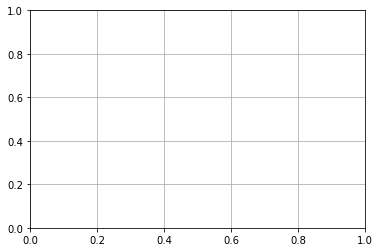

In [49]:
for iy in range(0,npv):
    ax = fig1.add_subplot(npv,1,iy+1)

    if iy == 0: # Pin
        ax.plot(xi,(Yk[iy,:].T/1e5), label='Medição')
        #ax.plot(xi,Ymk[iy,:].T/1e5, label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
        ax.set(ylim=(40,62))
        plt.grid(True)
    else: # H
        ax.plot(xi,Yk[iy,:].T, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T,label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(580, 850))
        plt.grid(True)
#ax.plot(xi,Yk[2,:].T, label='EKF')
ax.legend();
ax.set_xlabel('Time (nT)')
fig1.show()

0


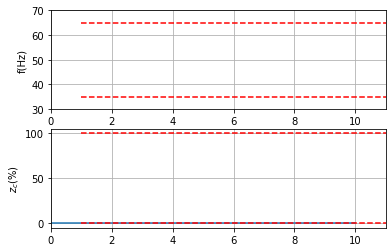

In [50]:
#% Restrição
umin  = np.array([35, 0]); np.transpose(umin);  # lower bounds of inputs
umax  = np.array([65, 100]); np.transpose(umax); # upper bounds of inputs
dumax = np.array([0.5, dzc_max]); np.transpose(dumax);
fig2=plt.figure()
label = ['f(Hz)',r'$z_c$(%)'];
for iu in range(0,nmv):
    ax2=fig2.add_subplot(nmv,1,iu+1)
    ax2.plot(xi,Uk[iu,:].T, label='Medição')
    ax2.plot([1,nsim],[umin[iu], umin[iu]],'--r')
    ax2.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
    ax2.set_ylabel(label[iu])
    ax2.set(xlim=(xi[0], nsim*ts))
    if iu==0:
        ax2.set(ylim=(30, 70))
        print(iu)
    plt.grid(True)